# Fatal Fungi: Enchancing Mushrrom Safety through Backprogated Multi-Layer Perceptron Neural Network Identification 

### CSS 581 - Final Project ML Implmentation

## Yasmine Subbagh

__Importing the Data__

The dataset used to train and test this neural netowrk is a mixture of two free open-source Kaggle datasets. This method was chosen in order to maximize the training dataset size to create a more accurate classifier. 

In [1]:
import kagglehub
import numpy as np # linear algebra
np.random.seed(10)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# download from kaggle
path1 = kagglehub.dataset_download("vishalpnaik/mushroom-classification-edible-or-poisonous")
path2 = kagglehub.dataset_download("ulrikthygepedersen/mushroom-attributes")

files1 = os.listdir(path1)
files2 = os.listdir(path2)

file1 = os.path.join(path1, "mushroom.csv")  
file2 = os.path.join(path2, "mushroom.csv")   

# Read the file into a list and clean up the byte-like characters
with open(file2, "r") as file:
    lines = file.readlines()

# Clean the lines
cleaned_lines = [line.replace("b'", "").replace("'", "").strip() for line in lines]

# Create a DataFrame
header = cleaned_lines[0].split(",")
data = [row.split(",") for row in cleaned_lines[1:]]

# Load the datasets
df1 = pd.read_csv(file1)
df2 = pd.DataFrame(data, columns=header)

# Print the size of the datasets
print(f"Dataset 1 Size: {df1.shape[0]} rows, {df1.shape[1]} columns")
print(f"Dataset 2 Size: {df2.shape[0]} rows, {df2.shape[1]} columns")


Dataset 1 Size: 61069 rows, 21 columns
Dataset 2 Size: 8124 rows, 23 columns


Next, the data needs to be cleaned up and combined into one dataset.

In [3]:
# Display the DataFrame
print(df2.head())

  cap-shape cap-surface cap-color bruises%3F odor gill-attachment  \
0         x           s         n          t    p               f   
1         x           s         y          t    a               f   
2                     s         w          t    l               f   
3         x           y         w          t    p               f   
4         x           s         g          f    n               f   

  gill-spacing gill-size gill-color stalk-shape stalk-root  \
0            c         n          k           e          e   
1            c                    k           e          c   
2            c                    n           e          c   
3            c         n          n           e          e   
4            w                    k           t          e   

  stalk-surface-above-ring stalk-surface-below-ring stalk-color-above-ring  \
0                        s                        s                      w   
1                        s                        s     

In [4]:
# Display the DataFrame
print(df1.head())

  class  cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0     p         15.26         x           g         o                    f   
1     p         16.60         x           g         o                    f   
2     p         14.07         x           g         o                    f   
3     p         14.17         f           h         e                    f   
4     p         14.64         x           h         o                    f   

  gill-attachment gill-spacing gill-color  stem-height  stem-width stem-root  \
0               e          NaN          w        16.95       17.09         s   
1               e          NaN          w        17.99       18.19         s   
2               e          NaN          w        17.80       17.74         s   
3               e          NaN          w        15.77       15.98         s   
4               e          NaN          w        16.53       17.20         s   

  stem-surface stem-color veil-type veil-color has

After exporloration of the dataset size and attributes, the executive decision to not to continue to use dataset 2 moving forward. This is because it is signifaclty smaller and the attributes do not align closely, lots of atributes would need to be cut to combine the dataset. 

Next, we need to identify duplicate rows and delete them. As well as replace missing catergoicals data with a "unkown" value to avoid deleting too many data rows. But rows with missing numerical data can be deleted.

In [5]:
# drop duplicates
print("Number of duplicate rows:", df1.duplicated().sum())
df1 = df1.drop_duplicates()

# drop rows with missing numerical values
numerical_columns = df1.select_dtypes(include=['int64', 'float64']).columns
print(f"Missing values in numerical columns:\n{df1[numerical_columns].isnull().sum()}")
df1 = df1.dropna(subset=numerical_columns)

# replace missing categorical values with 'Unknown'
categorical_columns = df1.select_dtypes(include=['object']).columns
print(f"Missing values in categorical columns:\n{df1[categorical_columns].isnull().sum()}")
df1[categorical_columns] = df1[categorical_columns].fillna('Unknown')

Number of duplicate rows: 146
Missing values in numerical columns:
cap-diameter    0
stem-height     0
stem-width      0
dtype: int64
Missing values in categorical columns:
class                       0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9855
gill-spacing            25062
gill-color                  0
stem-root               51536
stem-surface            38122
stem-color                  0
veil-type               57746
veil-color              53510
has-ring                    0
ring-type                2471
spore-print-color       54597
habitat                     0
season                      0
dtype: int64


We will not be dropping any columns as it is important for the model to be able to take into account as many attributes to be able to most accuretly classify the species, every detail is important and small nuacnces can indicate differenet species (which could change class type). Additionally, feature creating is not possible for this type of dataset. 

Next, we will rename and reformat the columns and data to be hot coded or scaled to be able to be used in the perceptron layers with accuracy.

In [6]:
# Modify 'class' column to 'edible' with one-hot encoding (0 for 'p' and 1 for 'e')
df1['edible'] = df1['class'].map({'p': 0, 'e': 1})

# One-hot encode the 'does-bruise-or-bleed' column
df1['does_bruise_or_bleed'] = df1['does-bruise-or-bleed'].map({'t': 1, 'f': 0})

# One-hot encode the 'has-ring' column
df1['has-ring'] = df1['has-ring'].map({'t': 1, 'f': 0})

# scale the cap diamter, stem height, and stem width to be within 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df1['cap-diameter'] = scaler.fit_transform(df1[['cap-diameter']])
df1['stem-height'] = scaler.fit_transform(df1[['stem-height']])
df1['stem-width'] = scaler.fit_transform(df1[['stem-width']])

# Use pd.get_dummies() to one-hot encode the 'gill-attachment' column
df_encoded_gillAttachment = pd.get_dummies(df1['gill-attachment'], prefix='gill_attachment', drop_first=False)
df_encoded_gillAttachment = df_encoded_gillAttachment * 1
df1 = pd.concat([df1, df_encoded_gillAttachment], axis=1)

# Use pd.get_dummies() to one-hot encode the 'cap-shape' column
df_encoded_cap_shape = pd.get_dummies(df1['cap-shape'], prefix='cap_shape', drop_first=False) * 1
df1 = pd.concat([df1, df_encoded_cap_shape], axis=1)

# Use pd.get_dummies() to one-hot encode the 'cap-surface' column
df_encoded_cap_surface = pd.get_dummies(df1['cap-surface'], prefix='cap_surface', drop_first=False) * 1
df1 = pd.concat([df1, df_encoded_cap_surface], axis=1)

# Use pd.get_dummies() to one-hot encode the 'cap-color' column
df_encoded_cap_color = pd.get_dummies(df1['cap-color'], prefix='cap_color', drop_first=False) * 1
df1 = pd.concat([df1, df_encoded_cap_color], axis=1)

# Use pd.get_dummies() to one-hot encode the 'gill-spacing' column
df_encoded_gill_spacing = pd.get_dummies(df1['gill-spacing'], prefix='gill_spacing', drop_first=False) * 1
df1 = pd.concat([df1, df_encoded_gill_spacing], axis=1)

# Use pd.get_dummies() to one-hot encode the 'gill-color' column
df_encoded_gill_color = pd.get_dummies(df1['gill-color'], prefix='gill_color', drop_first=False) * 1
df1 = pd.concat([df1, df_encoded_gill_color], axis=1)

# Use pd.get_dummies() to one-hot encode the 'stem-root' column
df_encoded_stem_root = pd.get_dummies(df1['stem-root'], prefix='stem_root', drop_first=False) * 1
df1 = pd.concat([df1, df_encoded_stem_root], axis=1)

# Use pd.get_dummies() to one-hot encode the 'stem-surface' column
df_encoded_stem_surface = pd.get_dummies(df1['stem-surface'], prefix='stem_surface', drop_first=False) * 1
df1 = pd.concat([df1, df_encoded_stem_surface], axis=1)

# Use pd.get_dummies() to one-hot encode the 'stem-color' column
df_encoded_stem_color = pd.get_dummies(df1['stem-color'], prefix='stem_color', drop_first=False) * 1
df1 = pd.concat([df1, df_encoded_stem_color], axis=1)

# Use pd.get_dummies() to one-hot encode the 'veil-color' column
df_encoded_veil_color = pd.get_dummies(df1['veil-color'], prefix='veil_color', drop_first=False) * 1
df1 = pd.concat([df1, df_encoded_veil_color], axis=1)

# Use pd.get_dummies() to one-hot encode the 'ring-type' column
df_encoded_ring_type = pd.get_dummies(df1['ring-type'], prefix='ring-type', drop_first=False) * 1
df1 = pd.concat([df1, df_encoded_ring_type], axis=1)

# Use pd.get_dummies() to one-hot encode the 'spore-print-color' column
df_encoded_spore_print_color = pd.get_dummies(df1['spore-print-color'], prefix='spore_print_color', drop_first=False) * 1
df1 = pd.concat([df1, df_encoded_spore_print_color], axis=1)

# Use pd.get_dummies() to one-hot encode the 'season' column
df_encoded_season = pd.get_dummies(df1['season'], prefix='season', drop_first=False) * 1
df1 = pd.concat([df1, df_encoded_season], axis=1)

# Use pd.get_dummies() to one-hot encode the 'habitat' column
df_encoded_habitat = pd.get_dummies(df1['habitat'], prefix='habitat', drop_first=False) * 1
df1 = pd.concat([df1, df_encoded_habitat], axis=1)

#only one value for veil-type, drop column
df1 = df1.drop(columns=['veil-type'])

# Drop the old columns
df1 = df1.drop(columns=['habitat', 'season', 'spore-print-color', 'spore_print_color_Unknown', 'ring-type', 'ring-type_Unknown', 'veil_color_Unknown', 'veil-color', 'stem-color', 'stem-surface', 'stem_surface_Unknown','class', 'does-bruise-or-bleed', 'gill-attachment', 'gill_attachment_Unknown', 'cap-shape', 'cap-surface', 'cap_surface_Unknown', 'cap-color', 'gill_spacing_Unknown', 'gill-spacing', 'gill-color', 'stem_root_Unknown', 'stem-root'])
print(df1.head())

   cap-diameter  stem-height  stem-width  has-ring  edible  \
0      0.240155     0.499705    0.164469         1       0   
1      0.261782     0.530366    0.175055         1       0   
2      0.220949     0.524764    0.170725         1       0   
3      0.222563     0.464917    0.153787         1       0   
4      0.230148     0.487323    0.165528         1       0   

   does_bruise_or_bleed  gill_attachment_a  gill_attachment_d  \
0                     0                  0                  0   
1                     0                  0                  0   
2                     0                  0                  0   
3                     0                  0                  0   
4                     0                  0                  0   

   gill_attachment_e  gill_attachment_f  gill_attachment_p  gill_attachment_s  \
0                  1                  0                  0                  0   
1                  1                  0                  0                

Now that we have finished up with the data pre-processing, we can do some quick data exploration.

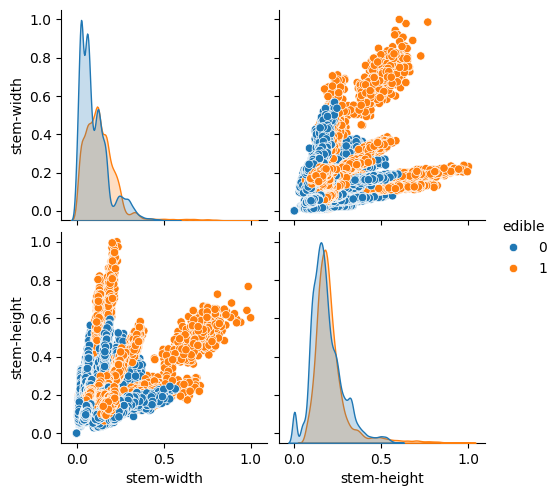

In [7]:
# Pairplot of a subset of features (you can select a few important ones to make it clearer)
subset = df1[['stem-width', 'stem-height', 'edible']] 
sns.pairplot(subset, hue='edible')  # Color by 'edible' class
plt.show()


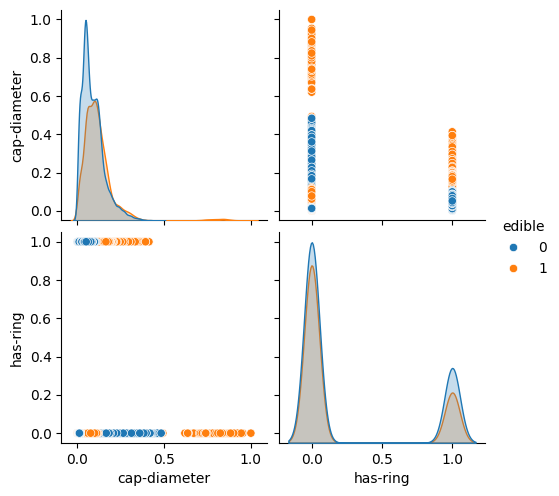

In [8]:
# Pairplot of a subset of features (you can select a few important ones to make it clearer)
subset = df1[['cap-diameter', 'has-ring', 'edible']] 
sns.pairplot(subset, hue='edible')  # Color by 'edible' class
plt.show()

As we can see from the pairplots above, there seams to be a strong grouping features to the edible (or not) classification. This indidcates that are model should be able to classify mushrooms given the data

           Feature  Importance
2       stem-width    0.079685
1      stem-height    0.055777
0     cap-diameter    0.054871
81    stem_color_w    0.034807
43  gill_spacing_d    0.028843


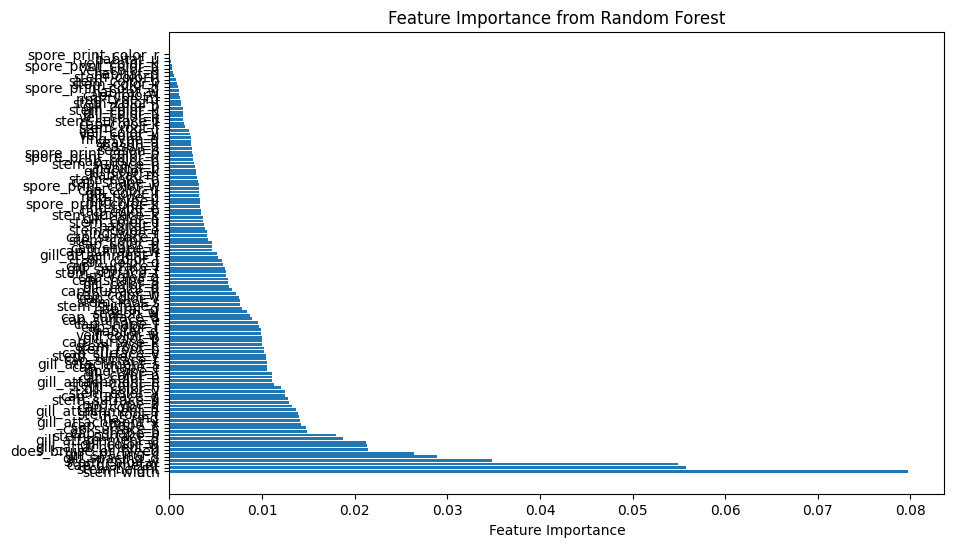

In [9]:
# Train a RandomForest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(df1.drop(columns=['edible']), df1['edible'])

# Get feature importances
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': df1.drop(columns=['edible']).columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# List the top 5 most important features
top_5_features = feature_importance_df.head(5)
print(top_5_features)

# Plot 
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

As we can see from the feature importance graph above, the stem-width has strong feature importance compared to the rest of the features. However, since the data is hot coded, the other features could not be truly represnted. 

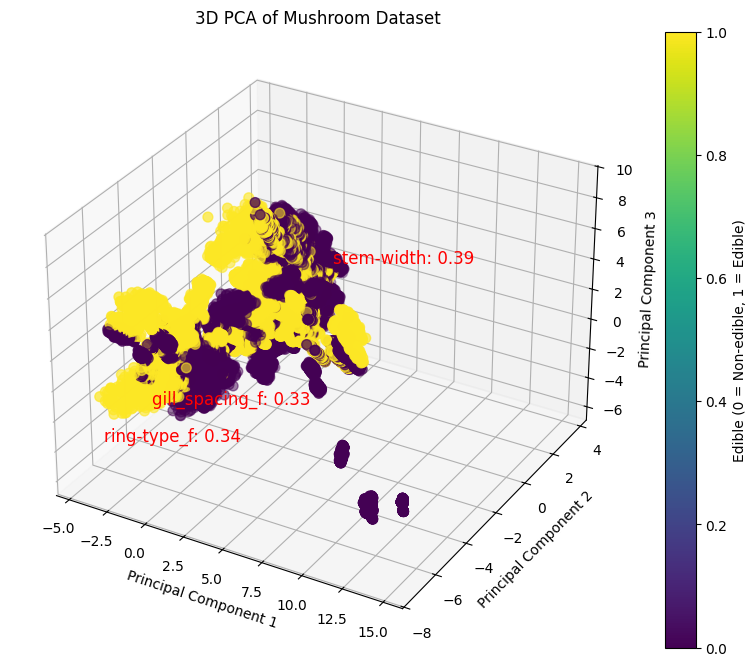

In [10]:
# Separate features and target
X = df1.drop(columns=['edible']) 
y = df1['edible'] 

# Perform PCA and reduce to 3 components
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['edible'] = y
components_df = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2', 'PC3'])

# Plot the 3D PCA plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Mushroom Dataset')

# Color points based on the 'edible' target (0 for non-edible, 1 for edible)
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['edible'], cmap='viridis', s=50)

fig.colorbar(scatter, label='Edible (0 = Non-edible, 1 = Edible)')
for i in range(3):  # Loop through the 3 components
    ax.text(
        pca_df.iloc[0, i], pca_df.iloc[1, i], pca_df.iloc[2, i], 
        f'{components_df.iloc[i].idxmax()}: {components_df.iloc[i].max():.2f}', 
        color='red', fontsize=12
    )

plt.show()

The 3D PCA shown above shows some grouping thats are clear in their inedibility due to stem_width, we saw this earlier in the feature importance, so this is supporting that the model will be able to classify with accuracy. While there are still groupings that can lead to easy classification by the 3 components, they are not as clear and seperated.

__Backpropogated Perceptron Neural Netowrk__

For this model, we will be using a 3 layer backpropogated percpetron neural nework. The activation function will be sigmoid to as ReLu could drop smaller features from contributing to the classification. 

In [11]:
# seperate features and target
X = df1.drop('edible', axis=1)
Y = df1['edible']
# spit data into training and testing sets 80:20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#reshape to vertical vector
Y_train = Y_train.values.reshape(-1, 1)
Y_test = Y_test.values.reshape(-1, 1)

# print splits
print("Training feature set shape:", X_train.shape)
print("Testing feature set shape:", X_test.shape)
print("Training labels shape:", Y_train.shape)
print("Testing labels shape:", Y_test.shape)

Training feature set shape: (48738, 116)
Testing feature set shape: (12185, 116)
Training labels shape: (48738, 1)
Testing labels shape: (12185, 1)


With the data now split, we need to build and train the model.

In [ ]:
# layer perceptron nueron counts
input_neurons = X.shape[1]
hidden_neurons_1 = 25  # first hidden layer
hidden_neurons_2 = 7   # second hidden layer
output_neurons = 1

# initialize random weights and biases
np.random.seed(42)
W1 = np.random.randn(input_neurons, hidden_neurons_1) * np.sqrt(2 / input_neurons)
b1 = np.zeros((1, hidden_neurons_1))
W2 = np.random.randn(hidden_neurons_1, hidden_neurons_2) * np.sqrt(2 / hidden_neurons_1)
b2 = np.zeros((1, hidden_neurons_2))
W3 = np.random.randn(hidden_neurons_2, output_neurons) * np.sqrt(2 / hidden_neurons_2)
b3 = np.zeros((1, output_neurons))

# activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# Hyperparameters
learning_rate = 0.05
epochs = 10000

# Training loop
for epoch in range(epochs):
    # Forward pass
    Z1 = np.dot(X_train, W1) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    Z3 = np.dot(A2, W3) + b3
    A3 = sigmoid(Z3)

    # Compute cross-entropy loss 
    epsilon = 1e-10  # To avoid log(0)
    loss = -np.mean(Y_train * np.log(A3 + epsilon) + (1 - Y_train) * np.log(1 - A3 + epsilon))
    
    # Backward pass
    dZ3 = A3 - Y_train
    dW3 = np.dot(A2.T, dZ3) / X_train.shape[0]
    db3 = np.sum(dZ3, axis=0, keepdims=True) / X_train.shape[0]
    
    dA2 = np.dot(dZ3, W3.T)
    dZ2 = dA2 * sigmoid_derivative(A2)
    dW2 = np.dot(A1.T, dZ2) / X_train.shape[0]
    db2 = np.sum(dZ2, axis=0, keepdims=True) / X_train.shape[0]
    
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * sigmoid_derivative(A1)
    dW1 = np.dot(X_train.T, dZ1) / X_train.shape[0]
    db1 = np.sum(dZ1, axis=0, keepdims=True) / X_train.shape[0]

    # Update weights and biases
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    # print loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 0.8804
Epoch 1, Loss: 0.8661
Epoch 2, Loss: 0.8529
Epoch 3, Loss: 0.8406
Epoch 4, Loss: 0.8293
Epoch 5, Loss: 0.8188
Epoch 6, Loss: 0.8091
Epoch 7, Loss: 0.8002
Epoch 8, Loss: 0.7919
Epoch 9, Loss: 0.7842
Epoch 10, Loss: 0.7771
Epoch 11, Loss: 0.7705
Epoch 12, Loss: 0.7645
Epoch 13, Loss: 0.7589
Epoch 14, Loss: 0.7537
Epoch 15, Loss: 0.7489
Epoch 16, Loss: 0.7444
Epoch 17, Loss: 0.7403
Epoch 18, Loss: 0.7365
Epoch 19, Loss: 0.7330
Epoch 20, Loss: 0.7297
Epoch 21, Loss: 0.7267
Epoch 22, Loss: 0.7239
Epoch 23, Loss: 0.7213
Epoch 24, Loss: 0.7189
Epoch 25, Loss: 0.7167
Epoch 26, Loss: 0.7147
Epoch 27, Loss: 0.7128
Epoch 28, Loss: 0.7110
Epoch 29, Loss: 0.7094
Epoch 30, Loss: 0.7078
Epoch 31, Loss: 0.7064
Epoch 32, Loss: 0.7051
Epoch 33, Loss: 0.7039
Epoch 34, Loss: 0.7028
Epoch 35, Loss: 0.7017
Epoch 36, Loss: 0.7008
Epoch 37, Loss: 0.6999
Epoch 38, Loss: 0.6990
Epoch 39, Loss: 0.6983
Epoch 40, Loss: 0.6975
Epoch 41, Loss: 0.6969
Epoch 42, Loss: 0.6963
Epoch 43, Loss: 0.695

Next we will test the accuracy of the model using the previsouly seperated testing data.

In [13]:
# Classify accuracy using test data
Z1_test = np.dot(X_test, W1) + b1
A1_test = sigmoid(Z1_test)
Z2_test = np.dot(A1_test, W2) + b2
A2_test = sigmoid(Z2_test)
Z3_test = np.dot(A2_test, W3) + b3
A3_test = sigmoid(Z3_test)

# Convert predictions to binary
Y_pred = (A3_test > 0.5).astype(int)

# Print accuracy and classification report
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

Test Accuracy: 0.6030

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.94      0.73      6820
           1       0.70      0.17      0.27      5365

    accuracy                           0.60     12185
   macro avg       0.65      0.56      0.50     12185
weighted avg       0.64      0.60      0.53     12185

